# RL for imbalanced 10-class classification

## Imports and data fetch

In [1]:
import os
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import gym

from datetime import datetime

from scipy.stats import gmean

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

from stable_baselines3 import DQN, PPO
from sb3_contrib import QRDQN
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

tf.test.gpu_device_name()

2023-01-07 12:59:07.468398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-07 12:59:08.138752: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-07 12:59:08.138852: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-07 12:59:08.138859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

'/device:GPU:0'

2023-01-07 12:59:09.635790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 12:59:09.638768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 12:59:09.638948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 12:59:11.188489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 12:59:11.188702: I tensorflow/compiler/xla/stream_executo

In [2]:
train  = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')

df = pd.concat([train,test]).drop(['id', 'label'], axis=1)

## Data preprocessing

In [3]:
NOMINAL_COLS = ['proto', 'service', 'state']
BINARY_COLS = ['is_sm_ips_ports', 'is_ftp_login']

for name in NOMINAL_COLS:
    df = pd.concat([df, pd.get_dummies(df[name], prefix=name)],axis=1)
    df.drop(name,axis=1,inplace=True)

## Reward bias for RL

In [4]:
attack_cat_list = np.unique(df['attack_cat'])

rw_factor = compute_class_weight(class_weight='balanced',
                                 classes=attack_cat_list,
                                 y=df['attack_cat'])

minority_threshold = gmean(rw_factor)

minority_classes = []

for idx, attack in enumerate(attack_cat_list):
    if rw_factor[idx] > minority_threshold:
        minority_classes.append(idx)

In [5]:
display(minority_threshold)
display(rw_factor)

2.9957855137446554

array([  9.62543892,  11.0636754 ,   1.57569253,   0.57871533,
         1.06274437,   0.43769088,   0.27706774,   1.84223207,
        17.05314361, 148.08793103])

## Data normalization, split, shuffle 

In [6]:
x = df.drop(['attack_cat'], axis=1).values

# Make the values [0, 1] for the RL environment
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
x = min_max_scaler.fit_transform(x)

dummies = pd.get_dummies(df['attack_cat'])
attack_cat_list = list(dummies.columns)
y = dummies.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, y_train = shuffle(x_train, y_train, random_state=42)

## Benchmark functions

In [9]:
models_benchmark = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1-score'])

def getMetrics(model_name, y_truth, y_pred, average):
    # Macro-avg is recommended to keep minority classes relevant
    # Weighted-avg is recommended to keep majority classes relevant
    print(f'Metrics {average}-averaged')
    acc = metrics.accuracy_score(y_truth, y_pred)
    rec = metrics.recall_score(y_truth, y_pred, average=average, zero_division=0)
    pre = metrics.precision_score(y_truth, y_pred, average=average, zero_division=0)
    f1s = metrics.f1_score(y_truth, y_pred, average=average, zero_division=0)

    models_benchmark.loc[model_name] = [acc, rec, pre, f1s]
    display(models_benchmark.loc[model_name])
    return

def getCM(model_name, y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10,10))
    plt.title(f'{model_name}', fontsize=20)

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=attack_cat_list, yticklabels=attack_cat_list)

    plt.xticks(rotation=45)
    plt.ylabel('Real outcome', fontsize=16)
    plt.xlabel('Predicted outcome', fontsize=16)
    plt.ioff()
    plt.show()
    return

## Environment for RL

In [10]:
class CustomEnv(gym.Env):
    def __init__(self, dataset=(x_train, y_train), rw_factor=rw_factor, minority_classes=minority_classes):
        
        super().__init__()

        self.x, self.y = dataset
        self.rw_factor = rw_factor
        self.idx = 0
        self.action_space = gym.spaces.Discrete(self.y.shape[1])
        self.observation_space = gym.spaces.Box(low=0, high=1,
                                                shape=(self.x.shape[1], ),
                                                dtype=np.float32)
        
        self.minority_classes = minority_classes
        self.step_counter = 0
        self.max_steps = len(self.x)

    def step(self, action):
        done = False
        
        # Reward management
        if int(action == self.expected_action):
            reward = self.rw_factor[self.expected_action]
        else:
            reward = -self.rw_factor[self.expected_action]
            # Done management 1 -> Stop progressing a bad guess is taken
            # on data from a minority class
            if self.expected_action in self.minority_classes:
                done = True
                
        # Observation management
        self.idx += 1
        if self.idx >= len(self.x):
            self.idx = 0
        obs = self.seq_observation()

        # Done management 2 -> If a whole sweep of X is achieved
        self.step_counter += 1
        if self.step_counter >= self.max_steps:
            done = True

        return obs, reward, done, {}

    def reset(self):
        # Start from failed position
        self.step_counter = 0
        obs = self.seq_observation()
        return obs
    
    def seq_observation(self):        
        obs = self.x[self.idx]
        self.expected_action = int(np.argmax(self.y[self.idx]))
        return obs

## Callback for best model auto-save

In [11]:
class SaveBest(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 0):
        super(SaveBest, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')        
        self.max_score = self.compute_f1()
    
    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            current_score = self.compute_f1()
            acc = metrics.accuracy_score(np.argmax(y_train, axis=1), y_train_pred)
            
            if current_score > self.max_score:
                self.max_score = current_score
                print(f'New best score at {self.num_timesteps}')
                print(f'Acc: {acc} - F1: {self.max_score}')
                print('----- ----- -----')
                self.model.save(self.save_path)

        return True
    
    def compute_f1(self) -> float:
        y_train_pred = self.model.predict(x_train)[0]
        current_score = metrics.f1_score(np.argmax(y_train, axis=1), y_train_pred, average='macro', zero_division=0)
        
        return current_score

In [12]:
log_dir = './model_dir/'
os.makedirs(log_dir, exist_ok=True)

train_env = CustomEnv()
train_env = Monitor(train_env, log_dir)

train_env.reset()

print(x_train.shape)

(206138, 196)


## Model creation / load / manual save

In [13]:
# Choose between DQN and PPO, other algogithms don't support Discrete action spaces
ALGO = 'PPO'
callback = SaveBest(check_freq=25_000, log_dir=log_dir)

In [14]:
model = QRDQN(policy='MlpPolicy', 
            env=train_env, 
            tensorboard_log=f'./{ALGO}')

In [15]:
# Change the name to load proper model
# model = QRDQN.load(path=f'{log_dir}/best_model.zip', env=train_env)

## Model training

In [16]:
# Min 5M timesteps for relevant results if training a new model

EPOCHS = 1
TIMESTEPS = 10e6

for i in range(1, EPOCHS+1):
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=f'{ALGO}_TB_LOG', callback=callback)

New best score at 1000
Acc: 0.09954496502343091 - F1: 0.07114176941291629
----- ----- -----
New best score at 3000
Acc: 0.10017561051334543 - F1: 0.07180721919854043
----- ----- -----
New best score at 5000
Acc: 0.10098574741192794 - F1: 0.072322199108585
----- ----- -----
New best score at 16000
Acc: 0.10137383694418302 - F1: 0.07284267999302985
----- ----- -----
New best score at 58000
Acc: 0.2894323220366939 - F1: 0.07669529450082321
----- ----- -----
New best score at 59000
Acc: 0.2977519913844124 - F1: 0.08977140569000036
----- ----- -----
New best score at 61000
Acc: 0.2740203164870135 - F1: 0.11583366442480378
----- ----- -----
New best score at 62000
Acc: 0.30673141293696454 - F1: 0.11972747833467803
----- ----- -----
New best score at 64000
Acc: 0.3770435339432807 - F1: 0.1668719891949589
----- ----- -----
New best score at 67000
Acc: 0.5000582134298382 - F1: 0.20326559245722303
----- ----- -----
New best score at 88000
Acc: 0.48114855097070897 - F1: 0.21173177049666386
----- 

## Compute metrics and CM for the current model on test split

Metrics macro-averaged


Accuracy     0.643388
Recall       0.532233
Precision    0.427931
F1-score     0.359515
Name: RUN, dtype: float64

----- ----- -----
Metrics weighted-averaged


Accuracy     0.643388
Recall       0.643388
Precision    0.825506
F1-score     0.686780
Name: RUN, dtype: float64

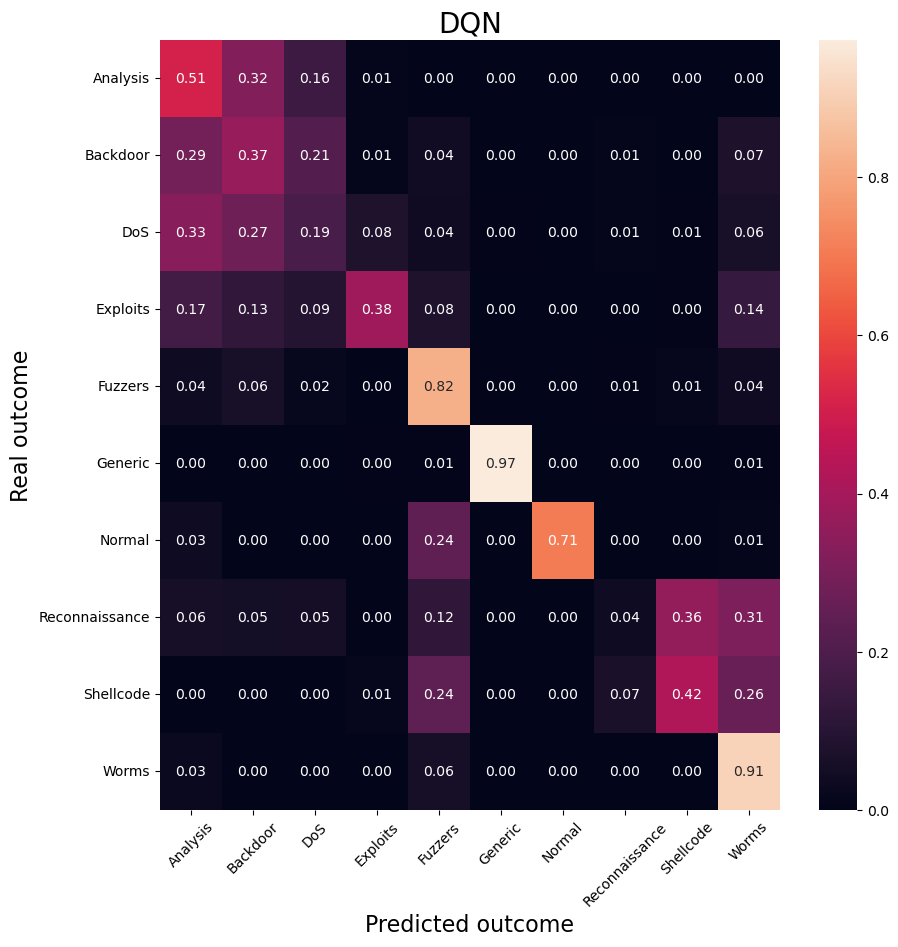

In [17]:
y_pred = model.predict(x_test)[0]

getMetrics('RUN', np.argmax(y_test, axis=1), y_pred, 'macro')
print('----- ----- -----')
getMetrics('RUN', np.argmax(y_test, axis=1), y_pred, 'weighted')
getCM('DQN', np.argmax(y_test, axis=1), y_pred)